# Trabalho da disciplina GCC128 - Inteligência Artificial

### Trabalho Prático 02 - K-Means

Professor: Ahmed Ali Abdalla Esmin

Alunos: Thiago Lima Pereira & Gustavo de Jesus Teodoro

A ideia dessa atividade é a fixação dos conhecimentos adquiridos em sala de aula, desenvolvendo dois códigos das aplicações que simule o algoritmo K-means. O primeiro código foi feito sem o uso de bibliotecas que já possuem os algoritmos do K-means implementados por padrão, já o segundo algoritmo foi desenvolvido utilizando a biblioteca ``Sklearn`` para fins comparativos.

### Base de dados

A base de dados utilizada será a ``Base de dados Irís``, popularmente conhecida na área em razão das inúmera aplicações de algoritmos à ela

### Algoritmo desenvolvido sem o uso de bibliotecas

Nesta seção, o algoritmo **K-means** é implementado do zero, utilizando apenas bibliotecas básicas do Python como `Numpy` e `Pandas` para manipulação de dados. O objetivo é demonstrar o funcionamento interno do processo de clusterização, passando pelas seguintes etapas:

- **Carregamento e Preparação dos Dados:** Leitura do dataset *Iris* e seleção apenas das colunas numéricas relevantes para a clusterização, desconsiderando a variável alvo (`target` ou `species`).  
- **Padronização:** Aplicação da normalização **z-score** nos atributos, para garantir que todas as variáveis tenham a mesma escala e não distorçam o cálculo das distâncias.  
- **Inicialização dos Centróides:** Escolha aleatória de `k` instâncias do conjunto de dados como centróides iniciais.  
- **Etapa de Atribuição:** Cada ponto do conjunto de dados é atribuído ao cluster cujo centróide esteja mais próximo, utilizando a **distância euclidiana** como métrica de proximidade.  
- **Etapa de Atualização:** Recalcula os centróides como a média dos pontos pertencentes a cada cluster. Caso algum cluster fique vazio, mantém-se o centróide anterior.  
- **Critério de Parada:** O algoritmo itera até que o deslocamento médio dos centróides entre duas iterações consecutivas seja inferior a uma tolerância (`tol`) ou até atingir o número máximo de iterações.  
- **Cálculo da Inércia:** Soma das distâncias quadráticas de cada ponto ao seu centróide, utilizada como métrica de qualidade da clusterização.  
- **Execução e Avaliação:** O algoritmo é executado para `k = 3` e `k = 5`, e em seguida é calculado o **Silhouette Score** (via `sklearn.metrics`) para avaliar a qualidade da separação dos clusters. Além disso, são exibidas métricas como número de iterações, inércia final, distribuição dos pontos entre os clusters e tempo de execução.  


In [ ]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

SEED = 42
np.random.seed(SEED)

def load_iris_df():
    possible_files = ["iris.csv", "Iris.csv", "/mnt/data/iris.csv", "/mnt/data/Iris.csv"]
    for path in possible_files:
        if os.path.exists(path):
            return pd.read_csv(path)
    from sklearn.datasets import load_iris
    data = load_iris(as_frame=True)
    df = data.frame
    df = df.rename(columns={
        "sepal length (cm)": "SepalLengthCm",
        "sepal width (cm)": "SepalWidthCm",
        "petal length (cm)": "PetalLengthCm",
        "petal width (cm)": "PetalWidthCm",
        "target": "target"
    })
    return df

def select_numeric_features_for_clustering(df):
    df_work = df.copy()
    drop_candidates = [c for c in df_work.columns if str(c).lower() in {"species","class","target","id"}]
    df_work = df_work.drop(columns=drop_candidates, errors="ignore")
    num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
    X = df_work[num_cols].to_numpy(dtype=float)
    return X, num_cols

def zscore_standardize(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0, ddof=0)
    stds[stds==0] = 1.0
    return (X - means) / stds

def kmeans(X, k, max_iters=100, tol=1e-4, random_state=SEED):
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    
    centroids = X[rng.choice(n, size=k, replace=False)]
    
    for it in range(max_iters):
        labels = []
        for xi in X:
            dists = [np.sum((xi - c)**2) for c in centroids]
            labels.append(np.argmin(dists))
        labels = np.array(labels)
        
        new_centroids = []
        for j in range(k):
            pts = X[labels==j]
            if len(pts) > 0:
                new_centroids.append(pts.mean(axis=0))
            else:
                new_centroids.append(centroids[j])
        new_centroids = np.array(new_centroids)
        
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if shift < tol:
            break
    
    inertia = 0
    for xi, li in zip(X, labels):
        inertia += np.sum((xi - centroids[li])**2)
    
    return centroids, labels, inertia, it+1

def run_experiments_kmeans():
    df = load_iris_df()
    X, cols = select_numeric_features_for_clustering(df)
    X_std = zscore_standardize(X)
    
    results = []
    for k in (3,5):
        t0 = time.perf_counter()
        centroids, labels, inertia, n_iter = kmeans(X_std, k)
        elapsed = time.perf_counter() - t0
        sil = silhouette_score(X_std, labels)
        _, counts = np.unique(labels, return_counts=True)
        
        print(f"\n=== K-means (SIMPLIFICADO) — k={k} ===")
        print(f"Inertia     : {inertia:.4f}")
        print(f"Silhouette  : {sil:.4f}")
        print(f"Iterações   : {n_iter}")
        print(f"Tempo (s)   : {elapsed:.4f}")
        print(f"Tamanhos clusters: {counts.tolist()}")
        
        results.append({
            "k": k,
            "inertia": inertia,
            "silhouette": sil,
            "iterations": n_iter,
            "time_s": elapsed,
            "cluster_sizes": counts.tolist()
        })
    
    print("\nResumo geral:")
    print(pd.DataFrame(results))
    return results

if __name__ == "__main__":
    _ = run_experiments_kmeans()



=== K-means (SIMPLIFICADO) — k=3 ===
Inertia     : 140.0328
Silhouette  : 0.4630
Iterações   : 7
Tempo (s)   : 0.0098
Tamanhos clusters: [56, 50, 44]

=== K-means (SIMPLIFICADO) — k=5 ===
Inertia     : 103.6161
Silhouette  : 0.3928
Iterações   : 7
Tempo (s)   : 0.0139
Tamanhos clusters: [22, 49, 12, 39, 28]

Resumo geral:
   k     inertia  silhouette  iterations    time_s         cluster_sizes
0  3  140.032753    0.463042           7  0.009845          [56, 50, 44]
1  5  103.616065    0.392824           7  0.013895  [22, 49, 12, 39, 28]


### Algoritmo desenvolvido com a biblioteca Sklearn

Nesta seção, o problema de **clusterização** é resolvido utilizando a biblioteca `scikit-learn` (`sklearn`), que oferece uma implementação otimizada e robusta do algoritmo **K-means**. O objetivo é comparar a simplicidade e a eficiência do uso de uma biblioteca especializada em relação à implementação manual (hardcore).

O código realiza as seguintes etapas:

- **Importação das Ferramentas:** Carrega as classes e funções necessárias do `sklearn`, como `KMeans` para a clusterização e `silhouette_score` para a avaliação dos resultados.  
- **Carregamento e Preparação dos Dados:** O dataset *Iris* é novamente carregado e, a partir dele, apenas as colunas numéricas são utilizadas para a clusterização. Em seguida, os dados são padronizados com **z-score** para garantir escalas comparáveis entre os atributos.  
- **Criação e Execução do Modelo:** Para cada valor de `k` (3 e 5), um objeto `KMeans` é instanciado com múltiplas inicializações (`n_init=20`) e ajustado aos dados com o método `fit_predict`, que já retorna os rótulos dos clusters atribuídos.  
- **Cálculo das Métricas:** Após o ajuste, são obtidas métricas de desempenho como **inércia** (soma das distâncias quadráticas intra-cluster) e **Silhouette Score**, além da quantidade de iterações até a convergência, tempo de execução e a distribuição dos pontos entre clusters.  
- **Exibição dos Resultados:** Para cada `k`, são exibidas as métricas, os tamanhos dos clusters e as coordenadas dos centróides padronizados. Um resumo final apresenta os resultados em formato de tabela, permitindo uma análise comparativa direta com a versão hardcore do algoritmo.



=== K-means (Scikit-learn) — k=3 ===
Inertia      : 139.8205
Silhouette   : 0.4599
Iterations   : 4
Tempo (s)    : 0.0332
Tamanho Clusters: [53, 50, 47]
Centroids (padronizados):
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0        -0.0502       -0.8834         0.3477        0.2815
1        -1.0146        0.8533        -1.3050       -1.2549
2         1.1360        0.0884         0.9962        1.0175

=== K-means (Scikit-learn) — k=5 ===
Inertia      : 90.8076
Silhouette   : 0.3455
Iterations   : 7
Tempo (s)    : 0.0211
Tamanho Clusters: [23, 28, 48, 29, 22]
Centroids (padronizados):
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0        -0.3528       -1.3330         0.1029        0.0123
1        -0.7492        1.4301        -1.2976       -1.2214
2         0.3817       -0.3910         0.6088        0.5658
3         1.3973        0.2332         1.1606        1.2173
4        -1.3523        0.1191        -1.3144       -1.2975

Resumo dos Resultados (Scikit-le

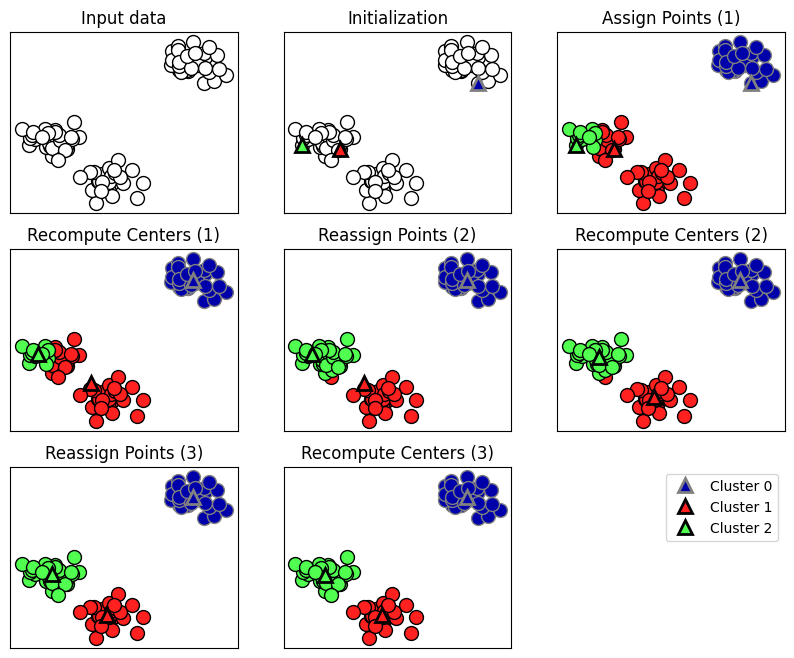

In [ ]:
import os
import numpy as np
import pandas as pd
import time

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import mglearn

df = load_iris_df()
X_raw, cols = select_numeric_features_for_clustering(df)  
X_std = zscore_standardize(X_raw)                          

sklearn_results = []

for k in (3, 5):
    t0 = time.perf_counter()
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    labels = km.fit_predict(X_std)
    elapsed = time.perf_counter() - t0

    inertia = km.inertia_
    sil = silhouette_score(X_std, labels, metric="euclidean")
    _, counts = np.unique(labels, return_counts=True)

    sklearn_results.append({
        "k": k,
        "inertia": float(inertia),
        "silhouette": float(sil),
        "iterations": int(getattr(km, "n_iter_", 0)),
        "time_s": float(elapsed),
        "cluster_sizes": counts.tolist()
    })

    print(f"\n=== K-means (Scikit-learn) — k={k} ===")
    print(f"Inertia      : {inertia:.4f}")
    print(f"Silhouette   : {sil:.4f}")
    print(f"Iterations   : {getattr(km, 'n_iter_', 0)}")
    print(f"Tempo (s)    : {elapsed:.4f}")
    print(f"Tamanho Clusters: {counts.tolist()}")
    print("Centroids (padronizados):")
    centroids_df = pd.DataFrame(km.cluster_centers_, columns=cols)
    print(centroids_df.round(4).to_string(index=True))

sklearn_results_df = pd.DataFrame(sklearn_results)
print("\nResumo dos Resultados (Scikit-learn):")
print(sklearn_results_df[["k","inertia","silhouette","iterations","time_s","cluster_sizes"]].to_string(index=False))


mglearn.plots.plot_kmeans_algorithm()


### Análise Comparativa dos Resultados

Para facilitar a comparação entre as duas abordagens (implementação manual e com `scikit-learn`), esta seção apresenta uma análise gráfica dos resultados obtidos. O objetivo é visualizar de forma clara o desempenho de cada versão do algoritmo em função do número de clusters (`k`).

Os gráficos de barras a seguir comparam duas métricas fundamentais:

- **Inércia:** mede a compactação dos clusters, isto é, o quão próximos os pontos estão de seus respectivos centróides.  
- **Silhouette Score:** avalia a qualidade da separação entre os clusters, indicando se eles estão bem definidos e distintos.  

Essa representação gráfica permite observar:

- As diferenças de desempenho entre a implementação "Hardcore" e a versão otimizada da biblioteca `scikit-learn`.  
- Como a escolha do valor de `k` (3 ou 5) impacta as métricas em cada uma das abordagens.  

Essa análise gráfica é essencial para consolidar as conclusões sobre a eficiência, a robustez e a praticidade de cada método de implementação do K-means.



=== K-means (SIMPLIFICADO) — k=3 ===
Inertia     : 140.0328
Silhouette  : 0.4630
Iterações   : 7
Tempo (s)   : 0.0124
Tamanhos clusters: [56, 50, 44]

=== K-means (SIMPLIFICADO) — k=5 ===
Inertia     : 103.6161
Silhouette  : 0.3928
Iterações   : 7
Tempo (s)   : 0.0145
Tamanhos clusters: [22, 49, 12, 39, 28]

Resumo geral:
   k     inertia  silhouette  iterations    time_s         cluster_sizes
0  3  140.032753    0.463042           7  0.012379          [56, 50, 44]
1  5  103.616065    0.392824           7  0.014506  [22, 49, 12, 39, 28]
Resumo Hardcore:
 k    inertia  silhouette  iterations   time_s        cluster_sizes
 3 140.032753    0.463042           7 0.012379         [56, 50, 44]
 5 103.616065    0.392824           7 0.014506 [22, 49, 12, 39, 28]

Resumo Sklearn:
 k    inertia  silhouette  iterations   time_s        cluster_sizes
 3 139.820496    0.459948           4 0.033172         [53, 50, 47]
 5  90.807592    0.345511           7 0.021130 [23, 28, 48, 29, 22]

Tabela compar

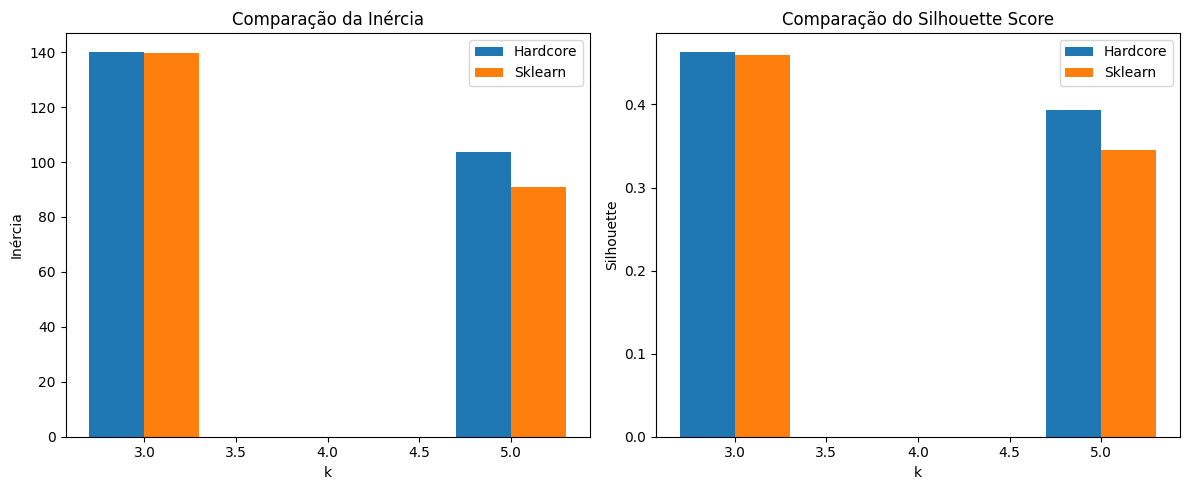

In [3]:
import matplotlib.pyplot as plt

hardcore_df = pd.DataFrame(run_experiments_kmeans())
sklearn_df = pd.DataFrame(sklearn_results)

print("Resumo Hardcore:")
print(hardcore_df.to_string(index=False))
print("\nResumo Sklearn:")
print(sklearn_df.to_string(index=False))

comp = pd.merge(hardcore_df, sklearn_df, on="k", suffixes=("_hardcore", "_sklearn"))
print("\nTabela comparativa:")
print(comp[["k","inertia_hardcore","inertia_sklearn","silhouette_hardcore","silhouette_sklearn",
            "time_s_hardcore","time_s_sklearn"]].to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].bar(comp["k"]-0.15, comp["inertia_hardcore"], width=0.3, label="Hardcore")
axes[0].bar(comp["k"]+0.15, comp["inertia_sklearn"], width=0.3, label="Sklearn")
axes[0].set_title("Comparação da Inércia")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inércia")
axes[0].legend()

axes[1].bar(comp["k"]-0.15, comp["silhouette_hardcore"], width=0.3, label="Hardcore")
axes[1].bar(comp["k"]+0.15, comp["silhouette_sklearn"], width=0.3, label="Sklearn")
axes[1].set_title("Comparação do Silhouette Score")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette")
axes[1].legend()

plt.tight_layout()
plt.show()


### Redução de Dimensionalidade com PCA

Foi realizada a redução de dimensionalidade da base *Iris* utilizando a técnica de **PCA** (Análise de Componentes Principais).  
Para isso, selecionou-se o **melhor valor de k** com base no **Silhouette Score** obtido pelo modelo `KMeans` da biblioteca `scikit-learn`.

Foram gerados dois experimentos de visualização:

- **1 Componente Principal:** os dados foram projetados em uma única dimensão, permitindo observar a separação linear dos clusters ao longo de um eixo. Os centróides também foram projetados e destacados no gráfico.  
- **2 Componentes Principais:** os dados foram projetados em duas dimensões, possibilitando uma visualização mais intuitiva da distribuição dos clusters no plano. Novamente, os centróides foram plotados para comparação.

Essas representações gráficas ajudam a entender como o algoritmo de clusterização organiza os dados em espaços de menor dimensionalidade, facilitando a análise visual e confirmando a qualidade da separação encontrada.



Melhor k (pelo silhouette Sklearn): k=3, Silhouette=0.4599


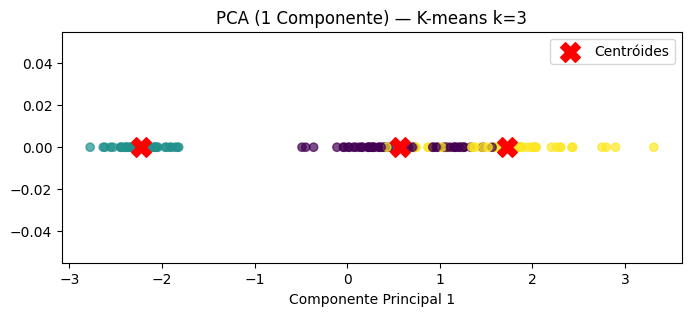

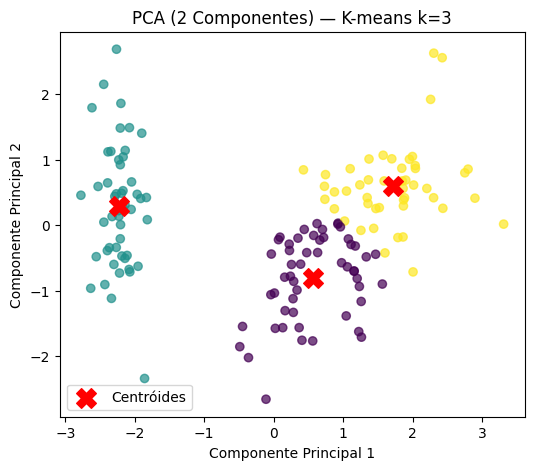

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

best_row = max(sklearn_results, key=lambda r: r["silhouette"])
best_k = best_row["k"]

print(f"\nMelhor k (pelo silhouette Sklearn): k={best_k}, Silhouette={best_row['silhouette']:.4f}")

km_best = SKKMeans(n_clusters=best_k, n_init=20, random_state=SEED)
labels_best = km_best.fit_predict(X_std)

pca1 = PCA(n_components=1, random_state=SEED)
X_pca1 = pca1.fit_transform(X_std)
centroids_pca1 = pca1.transform(km_best.cluster_centers_)

plt.figure(figsize=(8,3))
plt.scatter(X_pca1[:,0], [0]*len(X_pca1), c=labels_best, cmap="viridis", alpha=0.7)
plt.scatter(centroids_pca1[:,0], [0]*len(centroids_pca1), c="red", marker="X", s=200, label="Centróides")
plt.title(f"PCA (1 Componente) — K-means k={best_k}")
plt.xlabel("Componente Principal 1")
plt.legend()
plt.show()

pca2 = PCA(n_components=2, random_state=SEED)
X_pca2 = pca2.fit_transform(X_std)
centroids_pca2 = pca2.transform(km_best.cluster_centers_)

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_best, cmap="viridis", alpha=0.7)
plt.scatter(centroids_pca2[:,0], centroids_pca2[:,1], c="red", marker="X", s=200, label="Centróides")
plt.title(f"PCA (2 Componentes) — K-means k={best_k}")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()
